In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew
import feature_process_helper as fp
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

## Lasso 6

Taking the log of ALL numeric values impute w/ mean

### load data

In [164]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [165]:
train, test = fp.mssubclass(train, test)

In [166]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [167]:
train, test, y = log(train, test, y)

In [168]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.789759343621 seconds


### find optimal value of the Lasso alpha parameter

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

coeffs = {}
for alpha in alpha_ridge:
    r = Lasso(alpha=alpha, normalize=True, max_iter=1000000)
    r = r.fit(train, y)
    
grid_search = GridSearchCV(Lasso(alpha=alpha, normalize=True), scoring='neg_mean_squared_error',
                           param_grid={'alpha': alpha_ridge}, cv=10, n_jobs=-1)
grid_search.fit(train, y)

print grid_search.best_estimator_
print grid_search.score(train, y)

C:\Users\User\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
-0.01176265768


### inspect results

#### how do different values of alpha compare to the rmse?

In [8]:
alpha = alpha_ridge
rmse = list(np.sqrt(-grid_search.cv_results_['mean_test_score']))

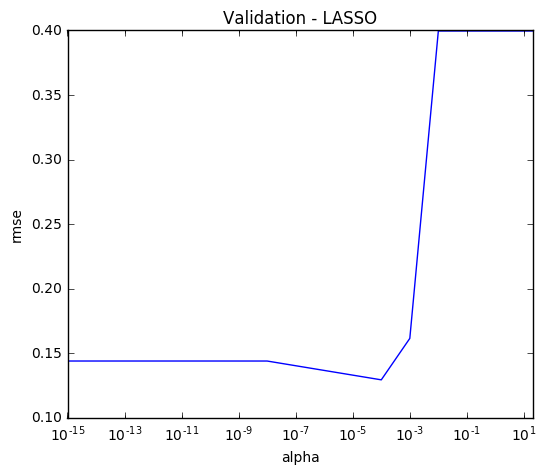

In [9]:
plt.figure(figsize=(6,5))
lasso_cv = pd.Series(rmse, index = alpha)
lasso_cv.plot(title = "Validation - LASSO", logx=True)
plt.xlabel("alpha")
plt.ylabel("rmse")

### fit lasso model with optimal alpha

In [169]:
lasso = Lasso(alpha=.0001, normalize=True, max_iter=1e6)
lasso = lasso.fit(train, y)

### inspect variable importance

In [170]:
coef = pd.Series(lasso.coef_, index = train.columns)

In [67]:
coef[coef != 0].index

Index([u'LotArea', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd', u'BsmtFinSF1', u'TotalBsmtSF', u'1stFlrSF',
       u'GrLivArea', u'BsmtFullBath',
       ...
       u'GarageCond_Fa', u'PoolQC_Ex', u'PoolQC_Gd', u'Fence_GdWo',
       u'MiscFeature_Othr', u'SaleType_New', u'SaleType_ConLD',
       u'SaleType_Con', u'SaleCondition_Abnorml', u'SaleCondition_Family'],
      dtype='object', length=103)

In [68]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 103 variables and eliminated the other 142 variables


In [69]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

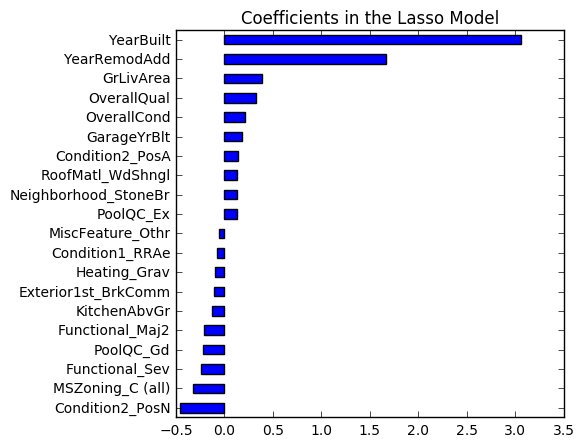

In [14]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### predict test data and create submission file

In [70]:
lasso.predict(test)

array([ 11.68927581,  11.95111481,  12.11327219, ...,  12.01075463,
        11.68626894,  12.29008417])

In [17]:
predictions = lasso.predict(test)
predictions = np.expm1(predictions)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'lasso6.csv'), sep=",", index = False)

score: .12090

## XGBoost 1

In [33]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

### load data

In [105]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

### transform data

In [106]:
train, test = fp.mssubclass(train, test)

In [107]:
def log(train, test, y):
    numeric_feats = train.dtypes[train.dtypes != "object"].index
        
    for i in (train, test):
        #log transform skewed numeric features:
        i[numeric_feats] = np.log1p(i[numeric_feats])

    y = np.log1p(y)
    return train, test, y

In [108]:
train, test, y = log(train, test, y)

In [109]:
train, test = fp.lotfrontage(train, test)
train, test = fp.garageyrblt(train, test)
train, test = fp.impute_mean(train, test)
train, test = fp.dummies(train, test)

0.720260998249 seconds


In [110]:
regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train, y)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train)
y_test = y
print("XGBoost score on training set: ", mean_squared_error(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test)

('XGBoost score on training set: ', 0.0058807337725166504)


### predict test data and create submission file

In [84]:
y_pred_xgb

array([ 11.75356579,  11.97429276,  12.10027695, ...,  12.04427624,
        11.69212246,  12.2768383 ], dtype=float32)

In [85]:
predictions = np.expm1(y_pred_xgb)
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'xgb1.csv'), sep=",", index = False)

score 0.12278

## Blended 1

lasso6 and xgb1

In [86]:
y_pred_xgb

array([ 11.75356579,  11.97429276,  12.10027695, ...,  12.04427624,
        11.69212246,  12.2768383 ], dtype=float32)

In [104]:
predictions = np.expm1((lasso.predict(test) + y_pred_xgb)/2)

In [95]:
test = pd.read_csv(os.path.join('data', 'test.csv'))
predictions = pd.DataFrame(predictions, columns=['SalePrice'])
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv(os.path.join('submission_files', 'blended2.csv'), sep=",", index = False)

score: .11768